<a href="https://colab.research.google.com/github/amifra8uni/LabCMP/blob/main/lab_4b_fra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB Session 4b (20/12/2020)

You will generate the Higgs mass spectrum, with signal and background, and perform fits to binned data. Then you can repeat the generation to emulate multiple experiments and perform some statistical analysis.

This notebook provides guidance to obtain a correct spectrum and fit it. At the end you will find a few questions to answer (by repeating some of the steps and making some plots).

The main steps are:
- Generate Gaussian signal
 - plot the distribution
- Generate exponential background
 - plot the distribution 
- Plot the distribution of data by stacking signal and background
- Obtain binned data from histogram
- Fit binned data with `curve_fit`
- Compute the signal significance defined as $S/\sqrt B$

At this point you can repeat the steps above to perform a few studies and make some plots, as asked for at the end of the notebook.

# Modules for this exercise

- `scipy.optimize` for fitting
- `scipy.integrate` for integration

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize as opt  
from scipy import integrate
from scipy.special import gamma

# Parameters
- Number of signal events
- Number of background events
- Higgs mass
- Higgs width due to detector resolution (intrinsic width is negligible)

In [ ]:
n_sig_0 = 100
n_bkg_0 = 10000

m_sig = 125 # GeV
w_sig = 0.02 # in %
w_sig *= m_sig

In [ ]:
print(w_sig)

2.5


# Histogram data
Boundaries and number of bins

In [ ]:
x_min = 0    # GeV
x_max = 200  # GeV
n_bins = 100
bin_width = (x_max-x_min)/n_bins # GeV
print('%d bins from %.1f to %.1f GeV' % (n_bins, x_min, x_max))
print('Bin width: %.2f GeV' % (bin_width))

100 bins from 0.0 to 200.0 GeV
Bin width: 2.00 GeV


## Generate signal sample

`n_sig_0` events with a Gaussian distribution around Higgs mass

In [ ]:
signal = [np.random.normal(m_sig, w_sig) for i in range(n_sig_0)]

## Plots signal distribution

Use [matplotlib.pyplot.hist](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.hist.html)

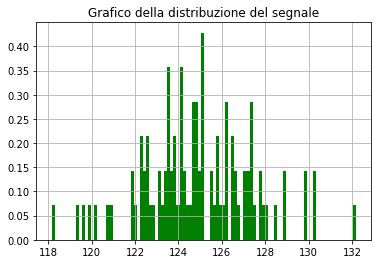

In [ ]:
%matplotlib inline
plt.hist(signal, facecolor='green', density=True, log=False, bins = n_bins)
plt.title("Grafico della distribuzione del segnale")
plt.grid()
plt.show()

## Generate background sample

`n_bkg_0` events with an exponential distribution. Use [numpy.random.exponential](https://numpy.org/doc/stable/reference/random/generated/numpy.random.exponential.html).

Choose an exponential parameter that populates bins with tens of events for mass of 200 GeV. For example, use `scale=80` in [numpy.random.exponential].

In [ ]:
background = [np.random.exponential(scale = 80) for i in range(n_bkg_0)]

## Plots background distribution
Use [matplotlib.pyplot.hist](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.hist.html)

Useful options:
- _bins=n_ : fix number of bins to _n_
- _hist=options_ : for example _hist='step'_ to show empty histogram
- _range=(min,max)_ : fix the boundaries of data in histogram. 
  - **NB**: this is different than using _xlim(min,max)_ which is only for visualization


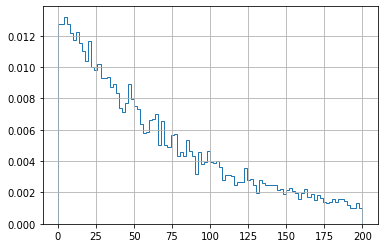

In [ ]:
%matplotlib inline
plt.hist(background, density=True, log=False, bins = n_bins, histtype = 'step', range=(x_min, x_max))
plt.grid()
plt.show()

## Stack signal and background data in the same histogram

If you have two data arrays `signal` and `background`, the following can stack `signal` on top of the `background`

```python
plt.hist((background, signal), bins=n_bins, label=('backgroud', 'signal'),
         color=('red', 'blue'), stacked=True, 
         histtype='step', range=(x_min, x_max))
```

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


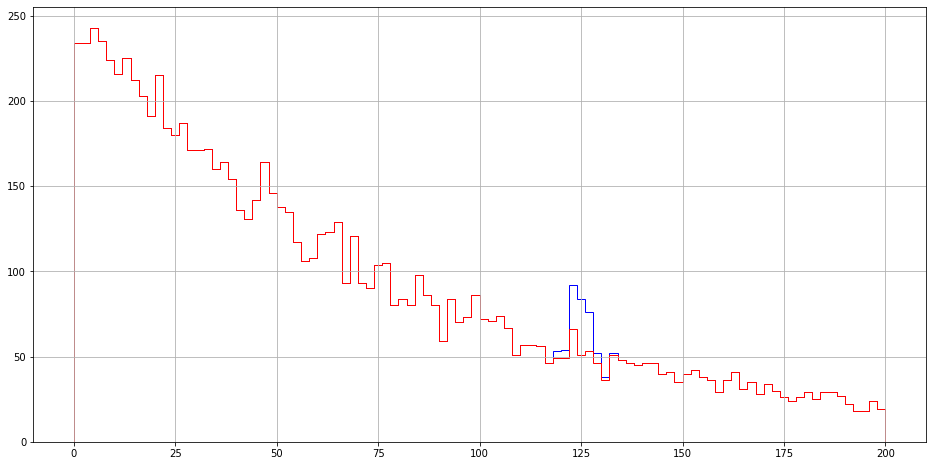

In [ ]:
plt.figure(figsize=(16,8))
plt.hist((background, signal), bins=n_bins, label=('backgroud', 'signal'),
         color=('red', 'blue'), stacked=True, 
         histtype='step', range=(x_min, x_max))
plt.grid()
plt.show()

## Merge signal and background samples

The data collected in an experiment contains both signal and background. Two samples separately stored in NumPy arrays can be merged with [numpy.concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) as follows:

```python
data = np.concatenate((a,b))
```
with the first positional argument of the function being a tuple of numpy arrays.

In [ ]:
data = np.concatenate((background, signal))

## Binned data

The data sample so far is unbinned: we have a number of signal and background events. 

Now we can create a binned version to be fitted. This is achieved with the `pyplot.hist` function which, as we saw, returns a list of counts for each bin and the bin boundaries
```python
binned_data, bins, _ = plt.hist(data, bins=n_bins, label='all data', color='black', histtype='step', range=(x_min, x_max))

```

Plot the merged data and make sure it is indeed the sum of the two sub-samples.

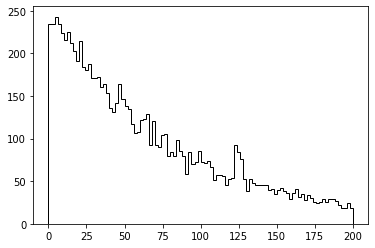

In [ ]:
binned_data, bins, _ = plt.hist(data, bins=n_bins, label='all data', color='black', histtype='step', range=(x_min, x_max))

## `bins` list

The list `bins` contains `n_bins + 1` values. These are run from the edge of the first bin to the edge of the last bin. Verify this.

In [ ]:
print("The number of bins is bins = {0}\nIn the list \"bins\" there are {1} values\n The first value is {2} and the last {3}".format(n_bins, len(bins), bins[0], bins[n_bins]))

The number of bins is bins = 100
In the list "bins" there are 101 values
 The first value is 0.0 and the last 200.0


## Center of bins (data along $x$ axis)

Using a comprehension, prepare a list `center_bins` from `bins` with length of `n_bins` which contains the center of each bin of the histogram. Check your result.

In [ ]:
center_bins = [(bins[i]+bins[i+1])/2 for i in range(n_bins)]

#checking the result
len(center_bins)
print("first bin = {0}, second bin = {1}, the center between the two is {2}".format(bins[0], bins[1], center_bins[0]))

first bin = 0.0, second bin = 2.0, the center between the two is 1.0


## Bin count (data along $y$ axis)

Verify that the list `binned data` has length `n_bins`.

In [ ]:
if bool(len(binned_data) == n_bins): print("Binned data ha la stessa lunghezza di n_bins")
else : print("binned data non è lungo n_bins")   

Binned data ha la stessa lunghezza di n_bins


## Fitting the histogram

We want to fit the binned data (`binned_data` as a function of `center_bins`) using the [optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) function.

The fit model has to be the sum of a Gaussian and an exponential.

Define three functions with proper arguments
1. `sig(x, Norm, mean, width)` for the signal Gaussian
2. `bkg(x, Norm, alpha)` for the background exponential
3. `total(x, NormSig, mean, width, NormBkg, alpha)` sum of signal and background

There is a total of 5 parameters to be fitted from the simulated data.

In [ ]:
def sig(x, Norm, mean, width):
  return Norm*np.exp(-(x-mean)*(x-mean)/(2*width*width))/(np.sqrt(2*np.pi)*width)
def bkg(x, Norm, alpha):
  return Norm*np.exp(-alpha*x)
def total(x, NormSig, mean, width, NormBkg, alpha):
  return sig(x, NormSig, mean, width) + bkg(x, NormBkg, alpha)

## Plot fit function

As a sanity check, plot the 3 functions and make sure they are implemented correctly.

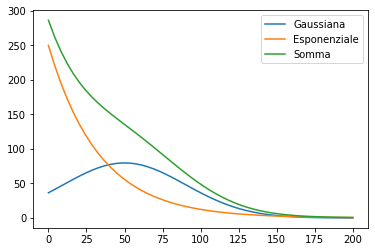

In [ ]:
x = np.linspace(0,200)
NormSig = 8000
mean = 50
width = 40 
NormBkg = 250
alpha = 0.03
plt.plot(x, sig(x, NormSig, mean, width), label = "Gaussiana")
plt.plot(x, bkg(x, NormBkg, alpha), label = "Esponenziale")
plt.plot(x, total(x, NormSig, mean, width, NormBkg, alpha), label = "Somma")
plt.legend()
plt.show()

## Initial conditions for the fit

It is always a good practice to provide some initial values for the parameters to be fitted, especially in a case like this one where there are 5 parameters and the data varies a lot across the spectrum. Initial values are passed to [optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) with the argument `p0`:
```python
pars, pars_cov = opt.curve_fit(..., p0=[500, m_sig, w_sig, 1000, alpha])
```

Recall that `pars` is the list of fitted parameters (in the order they appear in the definition of the fit function) and `pars_cov` is their covariance matrix that can be used to compute the uncertainty on each fitted parameter.

In [ ]:
pars, pars_cov = opt.curve_fit(total, xdata = center_bins, ydata = binned_data, p0=[500, m_sig, w_sig, 1000, alpha])

## Fitted parameters
- Print the parameters
- Print the covariance matrix

Are the fitted values close to the generated values?

In [ ]:
print(m_sig)
print(w_sig)
print(alpha)
print(pars)
print(pars_cov)
for i in range(5):
  print(pars[i], "+/-", pars_cov[i,i]**0.5)

125
2.5
0.03
[2.02827570e+02 1.24564759e+02 2.00841614e+00 2.51945365e+02
 1.26136098e-02]
[[1.58268680e+03 3.96298621e-02 1.04288023e+01 1.27067867e+01
  2.17991446e-03]
 [3.96298621e-02 1.91021587e-01 9.65447295e-04 2.37741312e-03
  7.40042658e-10]
 [1.04288023e+01 9.65447295e-04 1.95726825e-01 8.36008802e-02
  1.43543842e-05]
 [1.27067867e+01 2.37741312e-03 8.36008802e-02 7.47155280e+00
  4.20892299e-04]
 [2.17991446e-03 7.40042658e-10 1.43543842e-05 4.20892299e-04
  4.47501452e-08]]
202.82757017602157 +/- 39.78299634182088
124.56475911440191 +/- 0.4370601635741
2.0084161396773963 +/- 0.44241024475697904
251.94536537392239 +/- 2.733414129098214
0.012613609776684919 +/- 0.00021154230110920257


## Plot the histogram and fit

- Plot the data histogram
- Overlay the fitted function (total) with the fitted parameters
- Overlay the background function with the fitted parameters
- Print the fitted parameters with proper legend on the screen

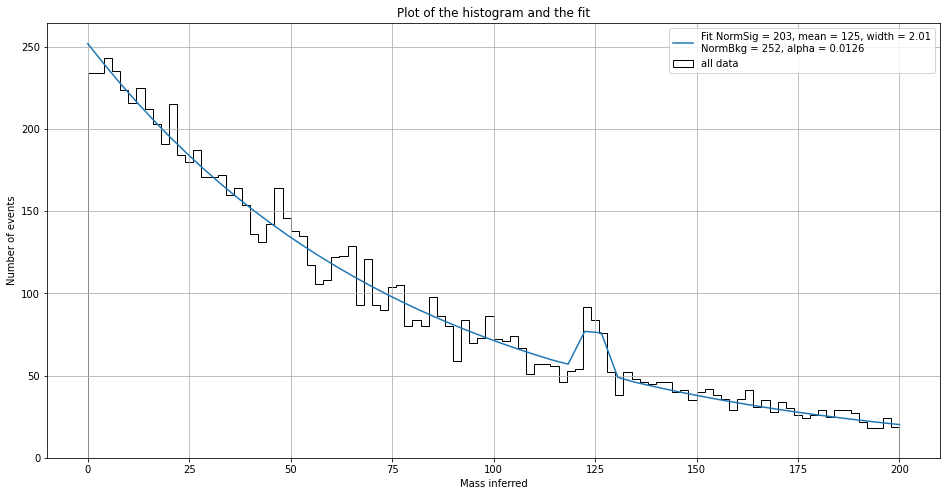

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.hist(data, bins=n_bins, label='all data', color='black', histtype='step', range=(x_min, x_max))
plt.plot(x, total(x, *pars), label = "Fit NormSig = %.0f, mean = %.0f, width = %.2f\nNormBkg = %.0f, alpha = %.4f" % tuple(pars))
plt.title("Plot of the histogram and the fit")
plt.xlabel("Mass inferred")
plt.ylabel("Number of events")
plt.grid()
plt.legend()
plt.show()

# Signal Significance

The signal significance is defined as

$$
S/\sqrt{B}\,,
$$

where

$$
\begin{align}
S &= \int_a^b sig(m)\, dm\\
B &= \int_a^b bkg(m)\, dm
\end{align}
$$

with $a = m_{\rm fitted} - 3\sigma_{\rm fitted}$ and $b = m_{\rm fitted} + 3\sigma_{\rm fitted}$.

Use [scipy.integrate.quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html) to compute the integral.

The result of a call to `scipy.integrate.quad` is a list with two elements:
1. the value of the integral
1. its uncertainty

## Compute $S$

In [ ]:
# Estremi degl integrali
a = pars[1] - 3*pars[2]
b = pars[1] + 3*pars[2]

# Integrale
S = integrate.quad(sig, a, b, args = (pars[0], pars[1], pars[2]))

## Compute $B$

In [ ]:
B = integrate.quad(bkg, a, b, args = (pars[3], pars[4]))

## Compute significance and print the result

In [ ]:
significanza = S/np.sqrt(B)

print("La significanza del segnale è: %.2f +/- %.1e" % (significanza[0],significanza[1]))

La significanza del segnale è: 8.05 +/- 8.5e-07


# Exercise 1

1. Fix the number of background events $N_B = 10000$ and vary the number of signal events $N_S$ in 
 `[10, 50, 100, 500, 1000]`
  - Plot the signficance as a function of $N_S$
  - You can now change $N_B$ and generate the same plot and show the data for different values of $N_B$
  - How does the significance depend on $N_S$ and $N_B$?

In [ ]:
%matplotlib notebook
m_sig = 125 # GeV
w_sig = 0.02 # in %
w_sig *= m_sig
n_sig_0 = [10, 20, 50, 100, 200, 300, 500, 700, 1000]
signif = np.array([])
for i in range(len(n_sig_0)):
  signal = [np.random.normal(m_sig, w_sig) for j in range(n_sig_0[i])]
  data = np.concatenate((background, signal))
  binned_data, bins, _ = plt.hist(data, bins=n_bins, label='all data', color='black', histtype='step', range=(x_min, x_max))
  center_bins = [(bins[i]+bins[i+1])/2 for i in range(n_bins)]
  pars, pars_cov = opt.curve_fit(total, xdata = center_bins, ydata = binned_data, p0=[500, m_sig, w_sig, 1000, alpha])

  # Estremi degl integrali
  a = pars[1] - 3*pars[2]
  b = pars[1] + 3*pars[2]

  # Integrale
  S = integrate.quad(sig, a, b, args = (pars[0], pars[1], pars[2]))
  B = integrate.quad(bkg, a, b, args = (pars[3], pars[4]))
  
  signif = np.append(signif, (S/np.sqrt(B))[0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[ 3.96266129  5.69546666  4.50928797  7.6116269  14.75959592 21.88281889
 34.95920271 48.82873304 70.08960282]


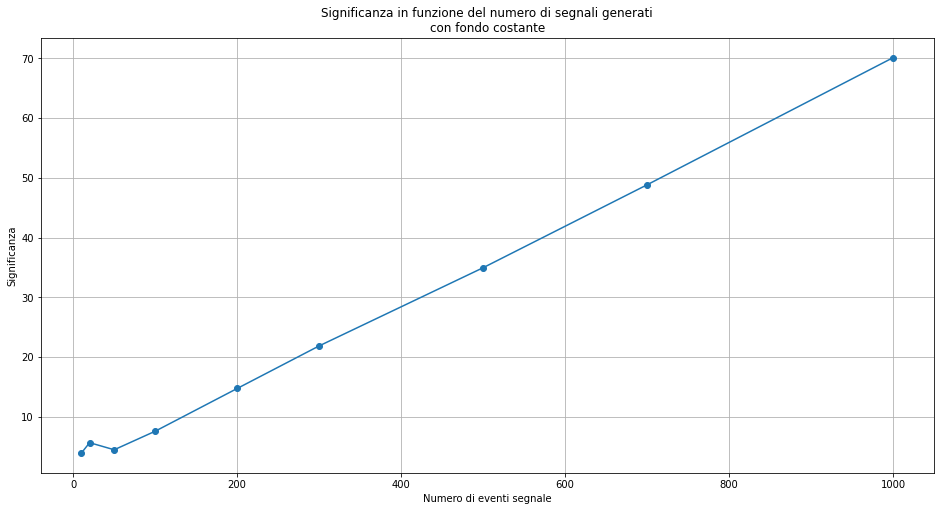

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,8))
# Plot significance as a function of Ns
print(signif)
plt.plot(n_sig_0, signif, 'o-')
plt.title("Significanza in funzione del numero di segnali generati\ncon fondo costante")
plt.xlabel("Numero di eventi segnale")
plt.ylabel("Significanza")
plt.grid()
plt.show()

# Exercise 2

2. Fix $N_B = 10000$ and $N_S = 200$. Vary the mass width in `[0.01, 0.2, 0.05, 0.10, 0.20, 0.50]`
  - Plot the significance as a function of the mass width 
  - Which mass width provide the best signal significance?

In [ ]:
%matplotlib notebook
n_sig_0 = 200
w_sig = np.array([0.01, 0.02, 0.05, 0.10, 0.20, 0.50])
w_sig = np.multiply(w_sig, m_sig)
signif = np.array([])

for i in range(len(w_sig)):
  signal = [np.random.normal(m_sig, w_sig[i]) for j in range(n_sig_0)]
  data = np.concatenate((background, signal))
  binned_data, bins, _ = plt.hist(data, bins=n_bins, label='all data', color='black', histtype='step', range=(x_min, x_max))
  center_bins = [(bins[i]+bins[i+1])/2 for i in range(n_bins)]
  pars, pars_cov = opt.curve_fit(total, xdata = center_bins, ydata = binned_data, p0=[500, m_sig, w_sig[i], 1000, alpha])

  # Estremi degl integrali
  a = pars[1] - 3*pars[2]
  b = pars[1] + 3*pars[2]

  # Integrale
  S = integrate.quad(sig, a, b, args = (pars[0], pars[1], pars[2]))
  B = integrate.quad(bkg, a, b, args = (pars[3], pars[4]))
  
  signif = np.append(signif, (S/np.sqrt(B))[0])

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


<IPython.core.display.Javascript object>

[1.96362081e+01 1.44582705e+01 9.10968805e+00 5.35460259e+00
            nan 2.62954191e+04]


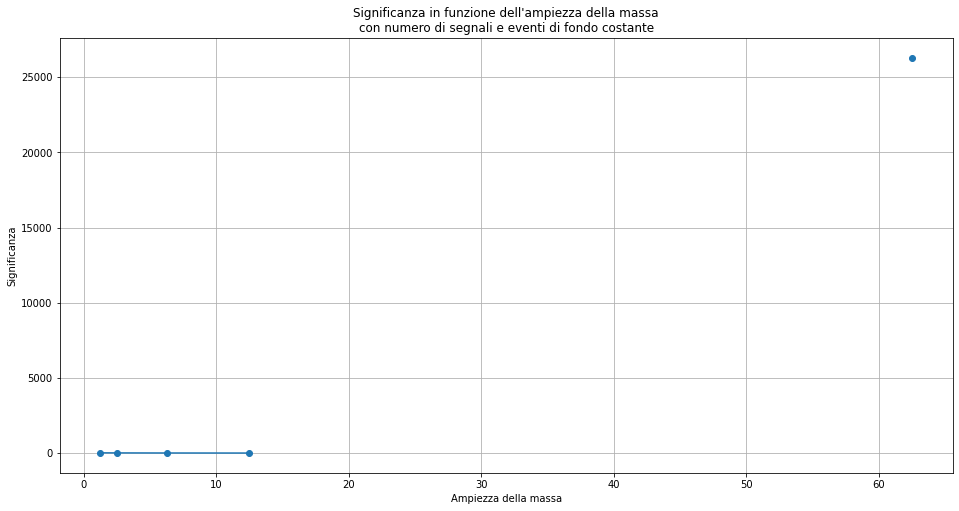

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,8))
# Plot significance as a function of Ns
print(signif)
plt.plot(w_sig, signif, 'o-')
plt.title("Significanza in funzione dell'ampiezza della massa\ncon numero di segnali e eventi di fondo costante")
plt.xlabel("Ampiezza della massa")
plt.ylabel("Significanza")
plt.grid()
plt.show()

# Exercise 3


3. Fix $N_B = 10000$ and $N_S = 200$ and repeat the experiments 1000 times
  - For each experiment generate the number of signal and background events from a Poisson distribution
    - mean of signal events: 200
    - mean of background events: 10000
  - Compute the significance for each experiment
  - Plot the distribution of significance for all experiments
  - Plot the distribution of $m_{fitted} - m_H$ for all experiments
  - Fit to a Gaussian and print the fitted $\mu$ and $\sigma$

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


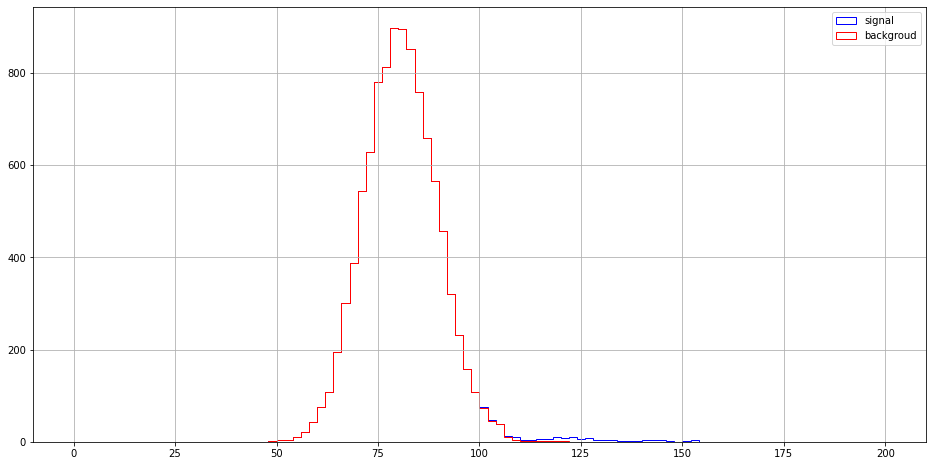

In [ ]:
#Questo pezzo di codice è una prova

%matplotlib inline
plt.figure(figsize=(16,8))
n_sig_0 = 100
n_bkg_0 = 10000
n_exp   = 1000

m_sig = 125 # GeV
w_sig = np.sqrt(m_sig)
signif = np.array([])
signal     = [np.random.poisson(m_sig) for j in range(n_sig_0)]
background = [np.random.poisson(80) for j in range(n_bkg_0)]
plt.hist((background, signal), bins=n_bins, label=('backgroud', 'signal'),
         color=('red', 'blue'), stacked=True, 
         histtype='step', range=(x_min, x_max))
plt.legend()
plt.grid()
plt.show()

In [ ]:
%matplotlib notebook
n_sig_0 = 100
n_bkg_0 = 10000
n_exp   = 1000

m_sig = 125 # GeV
w_sig = 0.02 # in %
w_sig *= m_sig
signif = np.array([])
Delta_m = np.array([])

#Assumo di poter approssimare le due distribuzioni poissoniane con una gaussiana
def total2(x, NormSig1, mean1, width1, NormSig2, mean2, width2):
  return sig(x, NormSig, mean1, width1) + sig(x, NormSig2, mean2, width2)

for i in range(n_exp):
  signal = [np.random.normal(m_sig, w_sig) for j in range(n_sig_0)]
  background = [np.random.exponential(scale = 80) for j in range(n_bkg_0)]
  data = np.concatenate((background, signal))
  binned_data, bins, _ = plt.hist(data, bins=n_bins, label='all data', color='black', histtype='step', range=(x_min, x_max))
  center_bins = [(bins[j]+bins[j+1])/2 for j in range(n_bins)]
  pars, pars_cov = opt.curve_fit(total, xdata = center_bins, ydata = binned_data, p0=[500, m_sig, w_sig, 1000, 0.012])

  # Estremi degl integrali
  a = pars[1] - 3*pars[2]
  b = pars[1] + 3*pars[2]

  # Integrale
  S = integrate.quad(sig, a, b, args = (pars[0], pars[1], pars[2]))
  B = integrate.quad(bkg, a, b, args = (pars[3], pars[4]))
  
  # Save the significance for each experiment and the fitted mass
  signif = np.append(signif, (S/np.sqrt(B))[0])
  Delta_m = np.append(Delta_m, pars[1] - m_sig)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

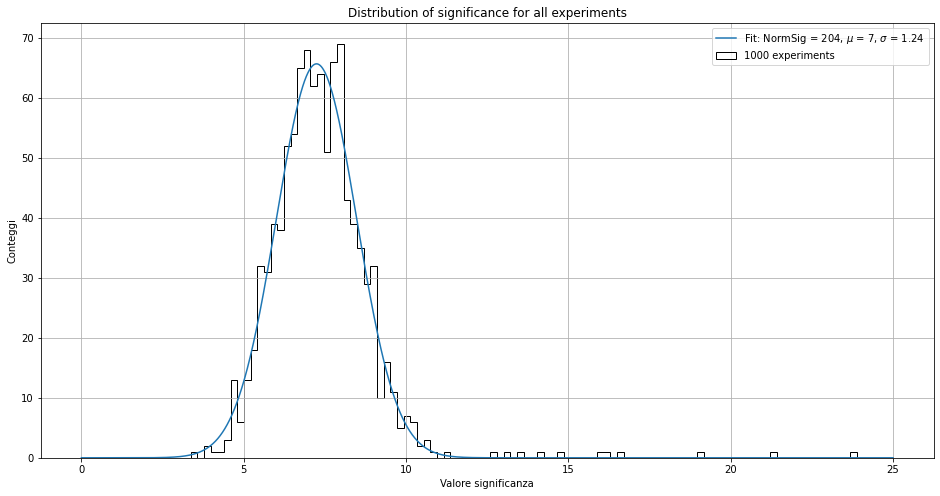

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,8))

# Plot the distribution of significance for all experiments
sig_binned_data, sig_bins, _ = plt.hist(signif, bins=n_bins, label='1000 experiments', color='black', histtype='step')
sig_center_bins = [(sig_bins[j]+sig_bins[j+1])/2 for j in range(n_bins)]
sig_pars, sig_pars_cov = opt.curve_fit(sig, xdata = sig_center_bins, ydata = sig_binned_data, p0=[500, 7, 3])

x = np.linspace(0, 25, 10000)
plt.plot(x, sig(x, *sig_pars), label = "Fit: NormSig = %.0f, $\mu$ = %.0f, $\sigma$ = %.2f" % tuple(pars))
plt.xlabel("Valore significanza")
plt.ylabel("Conteggi")
plt.grid()
plt.title("Distribution of significance for all experiments")
plt.legend()

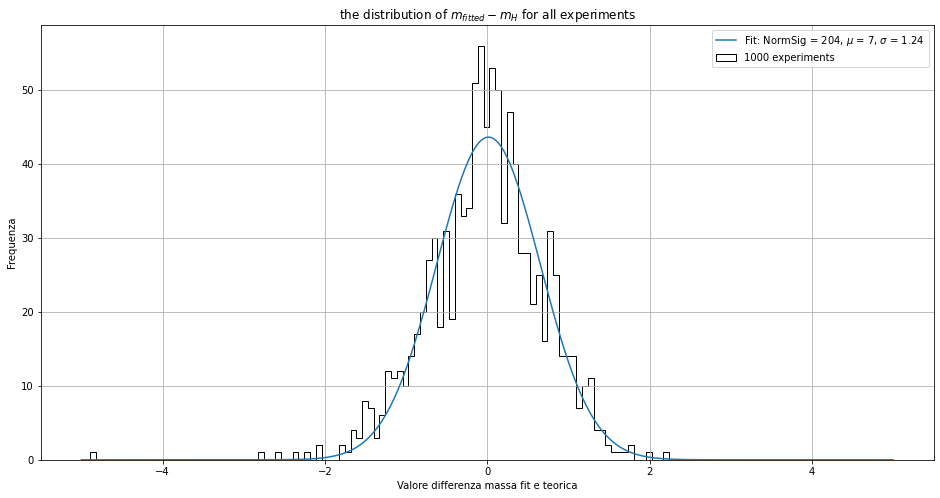

In [ ]:
%matplotlib inline
plt.figure(figsize=(16,8))

# Plot the distribution of $m_{fitted} - m_H$ for all experiments
Delta_m_binned_data, Delta_m_bins, _ = plt.hist(Delta_m, bins=n_bins, label='1000 experiments', color='black', histtype='step')
Delta_m_center_bins = [(Delta_m_bins[j]+Delta_m_bins[j+1])/2 for j in range(n_bins)]
Delta_m_pars, Delta_m_pars_cov = opt.curve_fit(sig, xdata = Delta_m_center_bins, ydata = Delta_m_binned_data, p0=[100, 0, 1])

x = np.linspace(-5, 5, 10000)
plt.plot(x, sig(x, *Delta_m_pars), label = "Fit: NormSig = %.0f, $\mu$ = %.0f, $\sigma$ = %.2f" % tuple(pars))
plt.xlabel("Valore differenza massa fit e teorica")
plt.ylabel("Frequenza")
plt.grid()
plt.title("the distribution of $m_{fitted} - m_H$ for all experiments")
plt.legend()

In [ ]:
# Fit to a Gaussian and print the fitted $\mu$ and $\sigma$